In [1]:
# Setup logging
from timeseria import logger
logger.setup(level='INFO')

# Set default plot type as image
import os
os.environ["DEFAULT_PLOT_TYPE"] = "image"

⚠️ In this notebook, plots are configured to be rendered as images because otherwise they won't display correctly on GitHub or when the notebook is loaded (usually because not [trusted](https://stackoverflow.com/questions/44943646/jupyter-notebook-not-trusted)). To get interactive plots, remove the line above (or change it to "interactive") and re-run the notebook.

# Temperature and humidity forecasting with LSTM

This notebook showcases the LSTM forecatser of [Timeseria](https://github.com/sarusso/Timeseria).

Let's start by loading an example time series, and resample it to one hour:

In [2]:
from timeseria import TEST_DATASETS_PATH
from timeseria.datastructures import TimeSeries
timeseries = TimeSeries.from_csv(TEST_DATASETS_PATH + 'humitemp_long.csv').resample('1h')

[INFO] timeseria.transformations: Using auto-detected sampling interval: 615.0s
[INFO] timeseria.transformations: Resampled 17910 DataTimePoints in 3191 DataTimePoints


Have a look at the time series

In [3]:
timeseries

Time series of #3191 points at 1h resolution, from point @ 1546477200.0 (2019-01-03 01:00:00+00:00) to point @ 1557961200.0 (2019-05-15 23:00:00+00:00)

Plot the time series

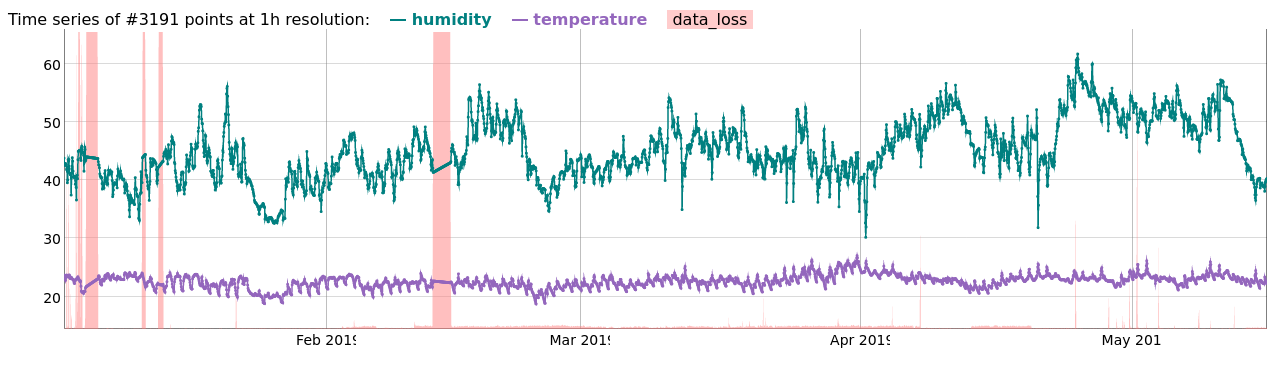

In [4]:
timeseries.plot()

## Model fit, usage and evaluation

Instantiate and fit the model:

In [5]:
from timeseria.models import LSTMForecaster
forecaster = LSTMForecaster(window=24, neurons=64, features=['values', 'hours'])
forecaster.fit(timeseries, epochs=30, verbose=True, reproducible=True)

Epoch 1/30
93/93 [==============================] - 1s 4ms/step - loss: 0.0198
Epoch 2/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0039
Epoch 3/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0034
Epoch 4/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0031
Epoch 5/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0030
Epoch 6/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0028
Epoch 7/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 8/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0026
Epoch 9/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0024
Epoch 10/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 11/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 12/30
93/93 [==============================] - 0s 4ms/step - loss: 0.0021
Epoch 13/30
93/93 [==============================

Call the `predict()` function of the model. This returns key-value data with the prediction values

In [6]:
forecaster.predict(timeseries)

{'humidity': 41.45781251050483, 'temperature': 22.01087811118259}

The timeseries on which to call the predict has to be at least of 24 hours (the window length)

In [7]:
try:
    forecaster.predict(timeseries[0:23])
except Exception as e:
    print(e)

The series length (23) is shorter than the model window (24)


The `forecats()` method returns not only data but also their data points, with the timestamp

In [8]:
forecaster.forecast(timeseries)

Time point @ 1557964800.0 (2019-05-16 00:00:00+00:00) with data "{'humidity': 41.45781251050483, 'temperature': 22.01087811118259}"

The `apply()` method allows instead to directly apply the model on a time series (by combining the forecasts with the real observations).

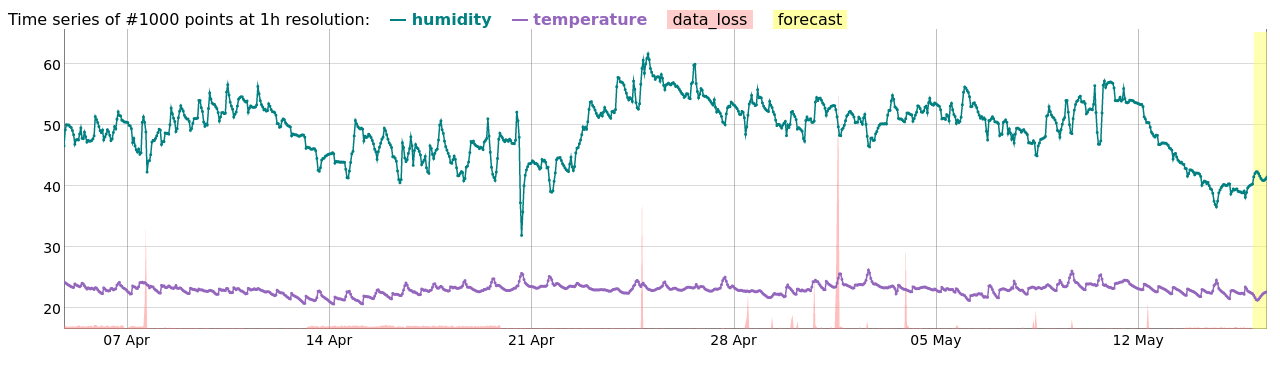

In [9]:
forecaster.apply(timeseries, steps=12)[-1000:].plot()

Evaluate the forecaster. By default, forecasters get evaluated with RMSE and MAE error metrics:

In [10]:
forecaster.evaluate(timeseries)

{'humidity_RMSE': 1.15405250053555,
 'humidity_MAE': 0.8408280784195243,
 'temperature_RMSE': 0.3158130676246483,
 'temperature_MAE': 0.22328342716990682}

For more advanced modes of evaluation, including using other error metrics, plotting the error distribution and/or the predictions, check out the "Forecasting - Advanced Evaluation" notebook.